# Objective: fine-tuning DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

import os
proj_path = "/content/drive/My Drive/Main Task"
os.chdir(proj_path)

1.6.0+cu101 False


In [4]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [6]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [7]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
os.chdir(os.path.join(proj_path,"content/detr"))
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


## Prepare the dataset for fine-tuning

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [8]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from PIL import Image

In [ ]:
dataDir=proj_path+'/content/data/POD/'
dataType='train'
annFile='{}annotations/POD_train.json'.format(dataDir)

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(nms)
nms = set([cat['supercategory'] for cat in cats])
print(nms)

['figure', 'formula', 'table']
{'none'}


In [ ]:
# load and display image
catIds = coco.getCatIds(catNms=['figure', 'formula', 'table']);
imgIds = coco.getImgIds(catIds=catIds);
# will return images having all objects mentioned in the catIds list

print(catIds)
print(len(imgIds))

[0, 1, 2]
30


/content/drive/My Drive/Main Task/content/data/POD//train/POD_0357.bmp


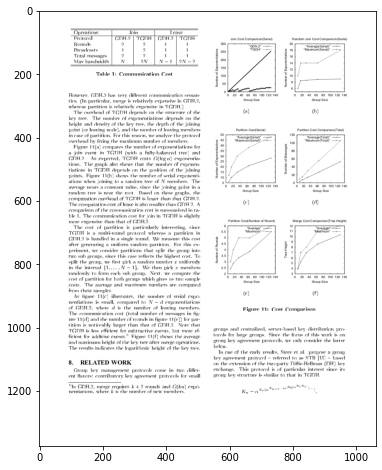

In [ ]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
#print(img_id)

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir,dataType,img['file_name'])
print(img_name)

I = io.imread(img_name)
plt.imshow(I)

In [ ]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
print(annIds)
_ = [print(i) for i in anns]

[4920, 4921, 4922, 4923]
{'id': 4920, 'image_id': 1264, 'segmentation': [], 'ignore': 0, 'area': 20414, 'iscrowd': 0, 'bbox': [373, 307, 346, 59], 'category_id': 2}
{'id': 4921, 'image_id': 1264, 'segmentation': [], 'ignore': 0, 'area': 33748, 'iscrowd': 0, 'bbox': [260, 435, 572, 59], 'category_id': 2}
{'id': 4922, 'image_id': 1264, 'segmentation': [], 'ignore': 0, 'area': 73514, 'iscrowd': 0, 'bbox': [232, 725, 623, 118], 'category_id': 0}
{'id': 4923, 'image_id': 1264, 'segmentation': [], 'ignore': 0, 'area': 75072, 'iscrowd': 0, 'bbox': [271, 987, 544, 138], 'category_id': 1}


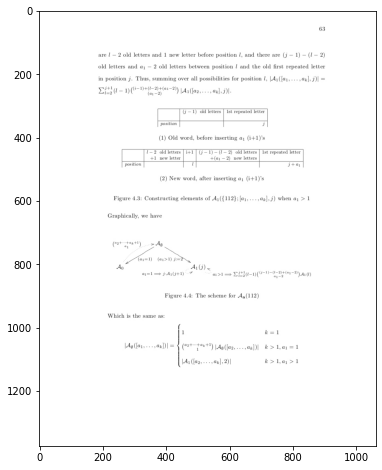

In [ ]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

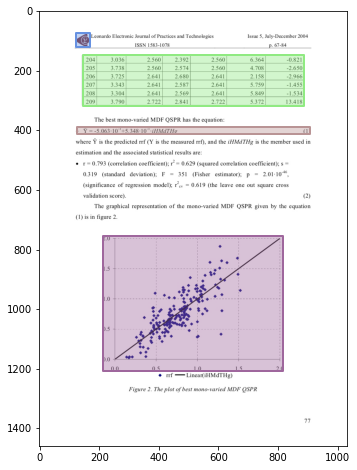

In [ ]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/mlk1337/651297e28199b4bb7907fc413c49f58f).

NB: There is a `--frozen_weights` argument. However,
i) I have yet to figure out how it is used,
ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

## Boilerplate variables
Caveat: the parameter name num_classes is misleading. It is actually the ID which DETR will reserve for its own no_object class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):

-   if you used the index n°0 for this class, then max_id = 0 and num_classes = max_id+1 = 1
-   if you used the index n°1 for this class, then max_id = 1 and num_classes = max_id+1 = 2

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [9]:
num_classes = 3

# Fine-tuned classes
finetuned_classes = [
    'figure', 'formula', 'table',
]

In [10]:
os.chdir(os.path.join(proj_path,"content/detr"))
print(os.getcwd())

#resume "/content/drive/My Drive/Main Task/content/detr/outputs/checkpoint.pth" \
#resume "/content/drive/My Drive/Main Task/content/detr/detr-r50_no-class-head.pth" \

/content/drive/My Drive/Main Task/content/detr


In [ ]:
!python main.py \
  --dataset_file "POD" \
  --coco_path "/content/drive/My Drive/Main Task/content/data/POD" \
  --output_dir "outputs" \
  --resume "/content/drive/My Drive/Main Task/content/detr/outputs/checkpoint.pth" \
  --num_classes $num_classes \
  --epochs 27 \
  --device "cpu"

Not using distributed mode
git:
  sha: 6ecf58fe5e8eb503cb3be015983756789a9964f5, status: has uncommited changes, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/drive/My Drive/Main Task/content/data/POD', dataset_file='POD', dec_layers=6, device='cpu', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=27, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=3, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='/content/drive/My Drive/Main Task/content/detr/outputs/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of p

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [ ]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

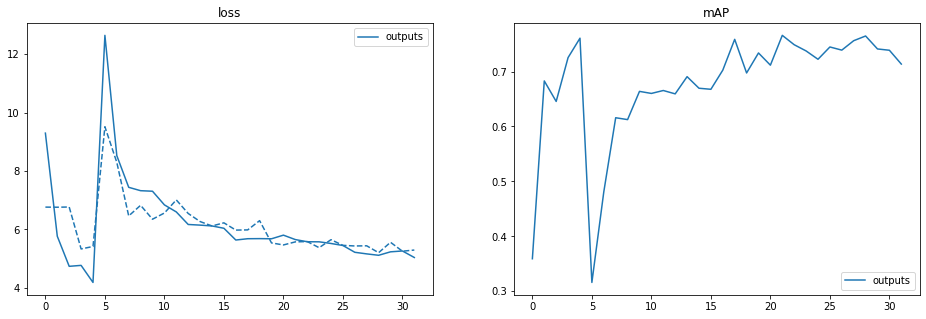

In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

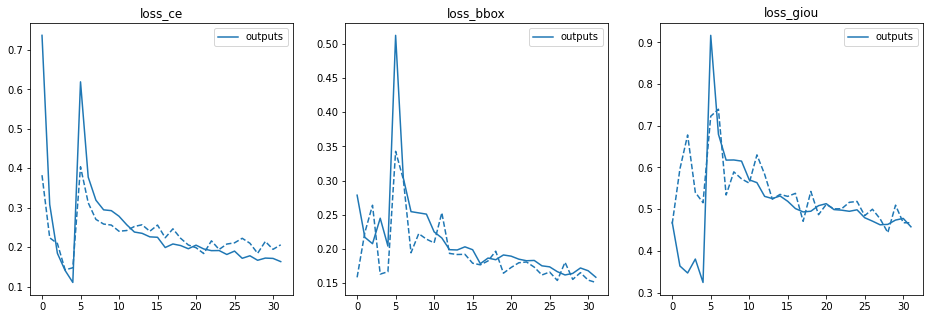

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

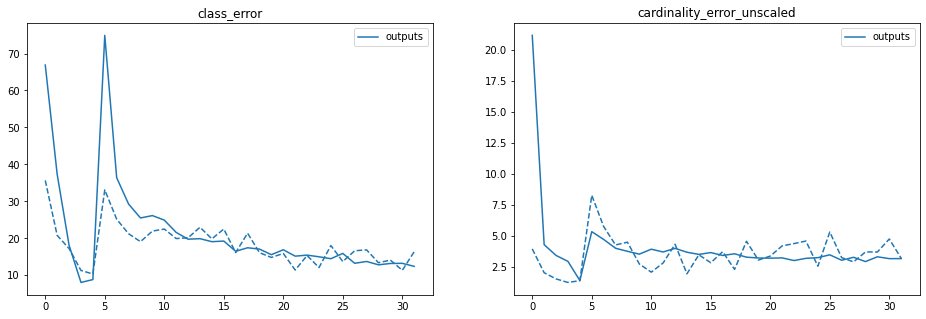

In [ ]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- Explanation: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [11]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### Boilerplate functions to display fine-tuned results

In [12]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [13]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.5, 0.0]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


### With a training image

/content/drive/My Drive/Main Task


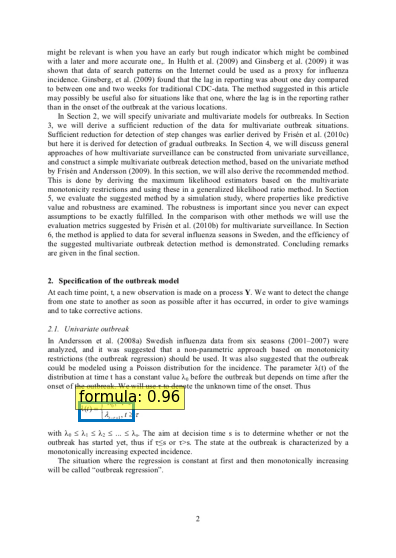

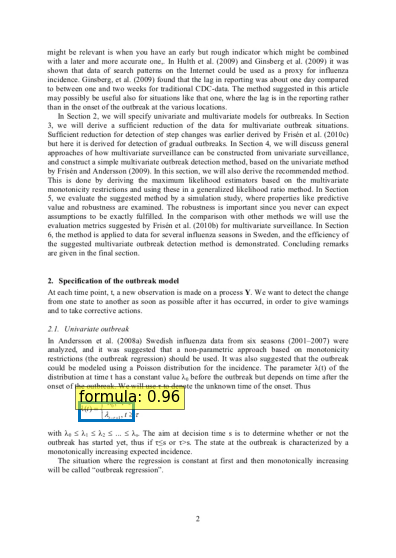

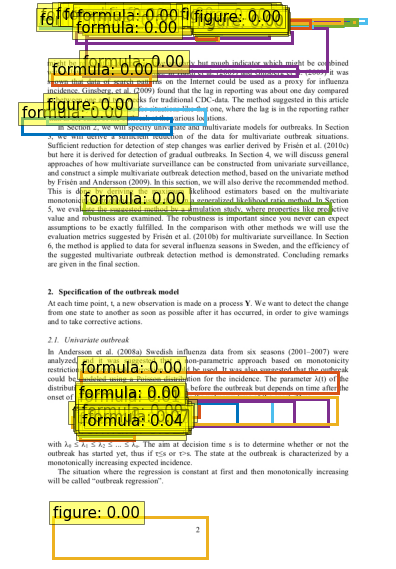

In [ ]:
train_path = proj_path+'/content/data/POD/train/'
imgs = os.listdir(train_path)
rand_img = imgs[np.random.randint(0,len(imgs))]

os.chdir(proj_path)
print(os.getcwd())
img_name = proj_path + '/content/data/POD/train/' + rand_img
#img_name = "/content/drive/My Drive/Main Task/content/data/POD//train/POD_1161.bmp"
im = Image.open(img_name)

run_worflow(im,
            model)

### With a validation image

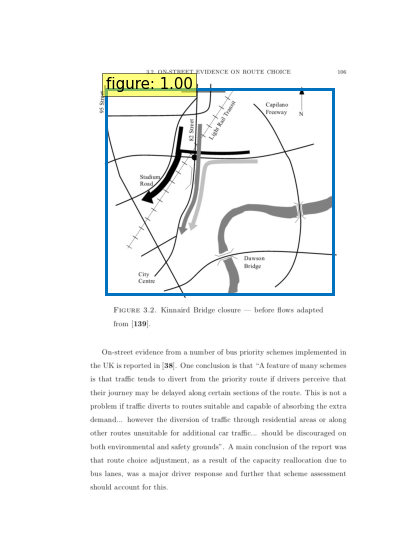

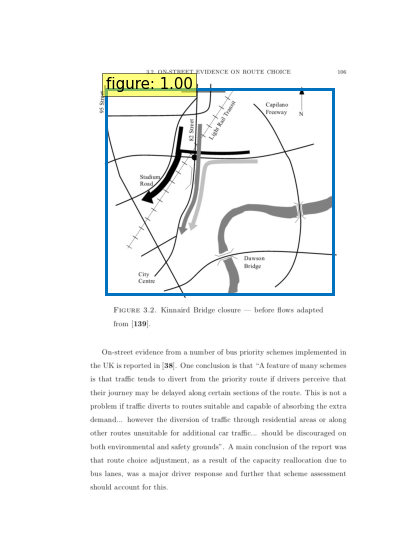

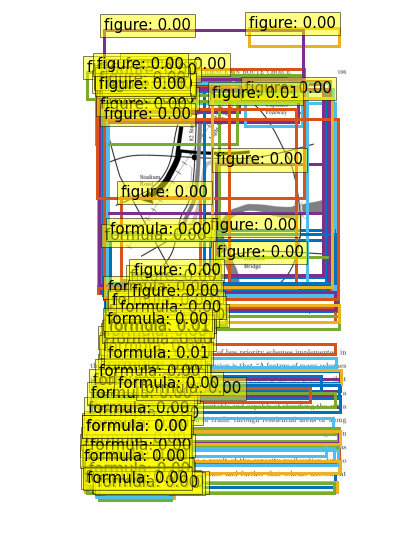

In [ ]:
val_path = proj_path+'/content/data/POD/val/'
imgs = os.listdir(val_path)
rand_img = imgs[np.random.randint(0,len(imgs))]

img_name = proj_path + '/content/data/POD/val/' + rand_img
im = Image.open(img_name)

run_worflow(im,
            model)

## Evaluate on all images

In [14]:
dataDir=proj_path+'/content/data/POD/'
dataType='all'
annFile='{}annotations/POD_all.json'.format(dataDir)

In [15]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.26s)
creating index...
index created!


In [16]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(nms)
nms1 = set([cat['supercategory'] for cat in cats])
print(nms1)

['figure', 'formula', 'table']
{'none'}


In [19]:
imgsDir = dataDir + '/' + dataType
imgIds = coco.getImgIds();
threshold = 0.5
cat_total = [0] * num_classes
cat_pred = [0] * num_classes

from tqdm.notebook import tqdm

for imgId in tqdm(imgIds[:10]):
  
  img = coco.loadImgs(imgId)[0]

  img_name = '%s/%s/%s'%(dataDir,dataType,img['file_name'])
  #print(img_name)

  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  #_ = [print(ann) for ann in anns]
  #I = io.imread(img_name)
  #plt.imshow(I)
  #coco.showAnns(anns, draw_bbox=True)

  im = Image.open(img_name)
  im1 = transform(im).unsqueeze(0)

  # propagate through the model
  outputs = model(im1)

  prob, boxes = filter_bboxes_from_outputs(outputs, threshold=0.5)
  #print(prob, boxes)
  #plot_finetuned_results(im, prob, boxes)

  for ann in anns:
    bb1 = list(ann['bbox'])
    cat1 = ann['category_id']
    cat_total[cat1] += 1
    #add del x, del y to x1, y1 to get x2, y2
    bb1[2] += bb1[0]; bb1[3] += bb1[1]
    for p, bb2 in zip(prob, boxes.tolist()):
      cat2 = int(p.argmax())
      if cat1==cat2:
        if bb_intersection_over_union(bb1,bb2) > threshold:
          cat_pred[cat1] += 1
          break

#print(cat_total); print(cat_pred)
avg_prec = [x/y for x, y in zip(cat_pred, cat_total)]
for i in range(num_classes):
  print ("%s : %f" % (nms[i],avg_prec[i]))
print ("%s : %f" % ("mean",sum(avg_prec)/len(avg_prec)) )


figure : 1.000000
formula : 0.863636
table : 1.000000
mean : 0.954545
